## Import librairies

In [1]:
%matplotlib notebook

import numpy as np
import scipy
import math
from scipy import sparse, linalg, spatial

from matplotlib import pyplot as plt


from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx
import random

## Load data

In [2]:
adjacency = np.load('new_adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

In [3]:
# the features of each track the adjacency matrix is based on
features = pd.read_csv('new_out_features.csv')

# track information: id, artist, title, genre used as signals on which the smoothness is computed
artists_titles = pd.read_csv('artists_titles.csv', )
artists_array = np.array(artists_titles[['artist']])
titles_array = np.array(artists_titles[['title']])
genres_array = np.array(artists_titles[['genre']])

## Graph computing

In [4]:
G = nx.Graph()
G = nx.from_numpy_matrix(adjacency)

### Layout choice

In [5]:
pos = nx.kamada_kawai_layout(G)

## Data visualization

In [6]:
fig1=plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, alpha =0.1)
fig1.savefig('graph.png')

<IPython.core.display.Javascript object>

C:\Users\vndk36\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


## Node selection

You can select the nodes you want to create a playlist with by clicking on the figure below. The artist, title and genre of the selected nodes are also shown. The last two selected nodes will be used by the next cells. 

In [7]:
# needed for the node selection
xypos = np.zeros((len(pos),2))

for i in range(0,len(pos)):
    xypos[i][0] = pos[i][0]
    xypos[i][1] = pos[i][1]

In [8]:
# callback implementing the node selection while clicking on the figure
class onClick(object):
    def __init__(self, xypos, artists, titles, genres, ax=None, fig =None):
        if ax is None:
            self.ax = plt.gca
        else:
            self.ax = ax
        if fig is None:
            self.fig = plt.gcf
        else:
            self.fig = fig
        self.xy = []
        self.xypos = xypos
        self.artists = artists
        self.titles = titles
        self.genres = genres
        self.clickedPos = []
        self.nbNodes = 2
        self.nbClicks = 0
        self.scats = []
        self.txts = []
        self.nodeLegend = ''
        self.d = []
        self.selectedNodes = []
        self.xplot = []
        self.yplot = []
        
    # called at each click     
    def __call__(self, event):
        self.nbClicks += 1
        clickX = event.xdata
        clickY = event.ydata
        # XY coordinates where the user clicked on the figure
        self.clickedPos.append([clickX, clickY])
        
        # if the user clicked for the first time ,needs to duplicate the point for future computations
        if self.nbClicks == 1:
            self.xy = [[clickX, clickY],[clickX, clickY]]
            
        # else, saves the coordinates of the last 2 clicked points and erase on the graph the node selected two clicks ago
        else:
            self.xy = self.clickedPos[len(self.clickedPos)-self.nbNodes:]
            ax.collections.remove(self.scats[self.nbClicks-2])
            
        # if the user clicked more than 2 times then also removes the legend of the node selected two clicks ago
        if self.nbClicks>2:
            ax.texts.remove(self.txts[self.nbClicks-3])            
        
        # computes the distance between the position of the clicks and the position of the nodes in order to find the closest
        # nodes (here in case the user misclicked a little, still finds the nodes)
        self.d = scipy.spatial.distance.cdist(self.xypos, self.xy).transpose()
        self.selectedNodes = np.argmin(self.d, 1)
        
        # finds the artist, title and genre of the selected node
        self.nodeLegend = self.artists[self.selectedNodes[1]][0]+':'+self.titles[self.selectedNodes[1]][0]+'('+self.genres[self.selectedNodes[1]][0]+')'
        
        # plots the two last selected nodes
        self.xplot = [self.xypos[self.selectedNodes][0][0], self.xypos[self.selectedNodes][1][0]]
        self.yplot = [self.xypos[self.selectedNodes][0][1], self.xypos[self.selectedNodes][1][1]]
        newScat = ax.scatter(self.xplot, self.yplot)
        
        # writes the legend of the node
        newText = ax.text(self.xplot[1]+0.1, self.yplot[1], self.nodeLegend)
        self.scats.append(newScat)
        self.txts.append(newText)
        
        # reload figure
        fig.canvas.draw()

## WAIT FOR THE PREVIOUS CELLS TO RUN BEFORE EXECUTING THIS CELL

<IPython.core.display.Javascript object>


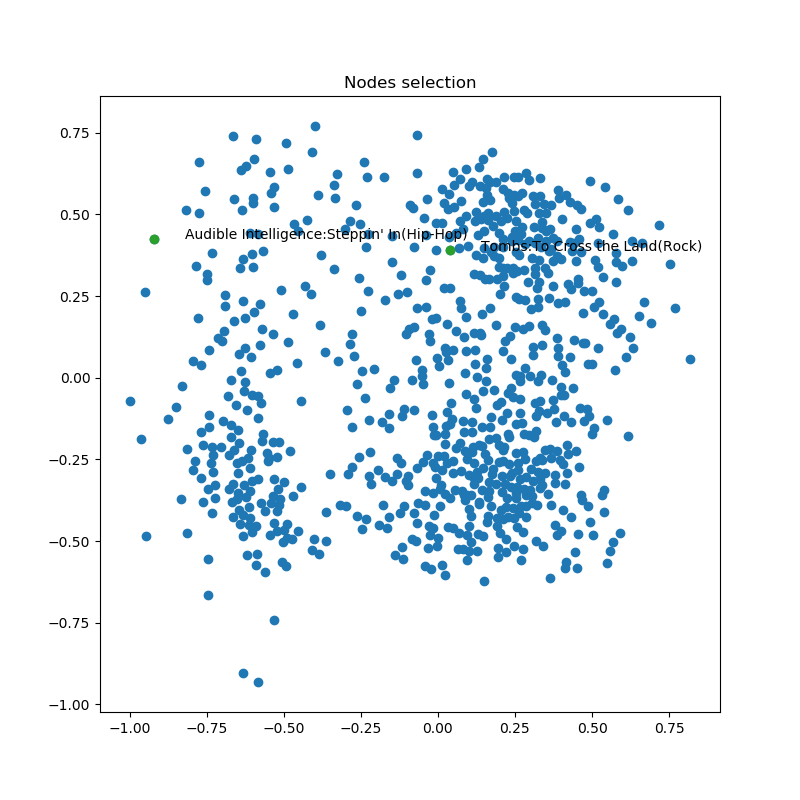

In [11]:
# interactive plot
plt.ion()
fig,ax = plt.subplots(figsize = (8, 8))
ax.set_title('Nodes selection')

# whole graph
initScat = ax.scatter(xypos[:, 0],xypos[:, 1])

# initialize the callback of the click action
oc = onClick(xypos, ax=ax, artists=artists_array, titles=titles_array, genres=genres_array)

# links the callback to the click action
cid = fig.canvas.mpl_connect('button_press_event', oc)

## SELECT TWO NODES BEFORE EXECUTING THE FOLLOWING CELLS

In [10]:
this is an intended error in order to stop the execution of the following cells (gives you the opportunity to select two nodes)

SyntaxError: invalid syntax (<ipython-input-10-cc294555893e>, line 1)

In [12]:
# disconnects the callback (stop the node selection)
fig.canvas.mpl_disconnect(cid)

In [13]:
# stores the last two selected nodes in an array
selected_nodes = oc.selectedNodes
selected_nodes

array([214,   9], dtype=int64)

## Paths computing

The diameter of the graph gives the minimal length a playlist should have in order to link any pair of tracks in the graph.

In [14]:
nx.diameter(G)

10

In [15]:
# determine the size of the playlist depending on the direct distance between the two nodes
lengths_dependency = [2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5]
shortcut = len(nx.shortest_path(G, selected_nodes[0], selected_nodes[1]))
max_path_length = lengths_dependency[shortcut]

In [16]:
max_path_length

5

In [17]:
def midpath_point_array(G, source, target, x=5, y=5):
    """Find all midpoints located at distance x from
    the source point and distance y from the target point
        
    midpath_point_array(networkx graph, index of source point,
                        index of target point, distance from source,
                        distance from target)
    """

    source_path_lengths = nx.single_source_dijkstra_path_length(G, source)
    target_path_lengths = nx.single_source_dijkstra_path_length(G, target)

    source_path_lengths_df = pd.DataFrame.from_dict(source_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    source_path_lengths_df.length = np.ceil(source_path_lengths_df.length)
    #all points at distance x from source
    source_path_lengths_df = source_path_lengths_df[source_path_lengths_df.length == x].drop(columns=['length'])

    target_path_lengths_df = pd.DataFrame.from_dict(target_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    target_path_lengths_df.length = np.ceil(target_path_lengths_df.length)
    #all points at distance y from target
    target_path_lengths_df = target_path_lengths_df[target_path_lengths_df.length == y].drop(columns=['length'])

    
    common_nodes = pd.merge(source_path_lengths_df, target_path_lengths_df, on='node')
    #midpath nodes is an array of nodes that can be used as a midpoint between start and target
    midpath_nodes = common_nodes.node.values
    return midpath_nodes

In [18]:
midpath_nodes = midpath_point_array(G, selected_nodes[0], selected_nodes[1], max_path_length, max_path_length)

In [19]:
midpath_nodes

array([ 27, 697, 246, 605, 406], dtype=int64)

In [20]:
midpath_rd = 697 #random.choice(midpath_nodes)

paths_start_mid = nx.all_simple_paths(G, selected_nodes[0], midpath_rd, max_path_length)
paths_mid_target = nx.all_simple_paths(G, midpath_rd, selected_nodes[1], max_path_length)

In [21]:
paths_s2m_array = []
paths_m2t_array = []

for path in paths_start_mid:
    paths_s2m_array.append(path)

for path in paths_mid_target:
    paths_m2t_array.append(path)

## Signal computing

Gets the signals on which the smoothness will be computed. You can choose one or several features on which the smoothness will be computed. Each signals will have a specific weight in the final smoothness of the path.

In [22]:
new_out_echonest = pd.read_csv('new_out_echonest.csv')
signals_array = np.array(new_out_echonest[['standard_dev', 'average', 'energy', 'liveness', 'tempo', 'speechiness']])

#normalize the feature in order to compare the values for the smoothness
signals_normalized = np.zeros((signals_array.shape[0],6))
for i in range(signals_array.shape[1]):
    signals_normalized[:,i] = (signals_array[:,i]-np.mean(signals_array[:,i]))/np.std(signals_array[:,i])
# Put the id of the signal you want to use in the smoothness calculus here:

selected_signals = [0, 1] # 0=standard deviation, 1=average, 2=energy, 3=liveness, 4=tempo, 5=speechiness

signals = signals_normalized[:, selected_signals]
signals = signals.transpose()
#signals = np.reshape(signals, (np.size(selected_signals), n_nodes))


## `paths_start_mid` and `paths_mid_target` are generators containing all the possible paths to reach the randomly chosen midpoint from the source or the target points

We need to compute the smoothness on all paths from source to midpoint to keep the smoothest one, do the same to the other half of paths and then join them.
This would give one possible playlist, to be sure to have not the worst one the process should be repeated with other randomly chosen midpoints (not already taken) to compare the smoothness of other possible paths and keep the best one.


## Smoothness

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

In [23]:
def compute_smoothness(source_to_mid_path, mid_to_target_path, signal):
    
    "Computes the smoothness of one or several signals over all the paths it is given"
    
    nb_signals = np.size(signals, 0)
    nb_paths_s2m = np.size(source_to_mid_path, 0)
    nb_paths_m2t = np.size(mid_to_target_path, 0)
    nb_nodes_path = np.size(source_to_mid_path, 1)
    paths_s2m_smoothness = np.zeros([nb_signals, nb_paths_s2m])
    paths_m2t_smoothness = np.zeros([nb_signals, nb_paths_m2t])
    
    # for each signal
    for signal_index in range(0, nb_signals):
        signal = signals[signal_index]
        # for each path between the starting node and the middle node
        for path_s2m_index in range(0, nb_paths_s2m):
            path = source_to_mid_path[path_s2m_index]
            for node_index in range(0, nb_nodes_path-1):
                nodes = [path[node_index], path[node_index+1]]
                # computes the smoothness between two consecutive nodes of the path
                smoothness = adjacency[nodes[0], nodes[1]]*np.power(signal[nodes[1]]-signal[nodes[0]] ,2)
                # computes the smoothness over the whole path
                paths_s2m_smoothness[signal_index, path_s2m_index] += smoothness
        
        # for each path between the middle node and the ending node
        for path_m2t_index in range(0, nb_paths_m2t):
            path = mid_to_target_path[path_m2t_index]
            for node_index in range(0, nb_nodes_path-1):
                nodes = [path[node_index], path[node_index+1]]
                smoothness = adjacency[nodes[0], nodes[1]]*np.power(signal[nodes[1]]-signal[nodes[0]] ,2)
                paths_m2t_smoothness[signal_index, path_m2t_index] += smoothness
    
    return paths_s2m_smoothness, paths_m2t_smoothness

In [24]:
def find_path_lowest_smoothness(source_to_mid_path, mid_to_target_path, signal):
    
    "finds the paths with the lowest overall smoothness (sum of the smoothness computed for each signals)"
    
    nb_signals = np.size(signal, 0)
    nb_paths_s2m = np.size(source_to_mid_path, 0)
    nb_paths_m2t = np.size(mid_to_target_path, 0)
    nb_nodes_path = np.size(source_to_mid_path, 1)
    all_signals_smoothness_s2m = np.zeros([1, nb_paths_s2m])
    all_signals_smoothness_m2t = np.zeros([1, nb_paths_m2t])
    
    
    # computes the smoothness of eqch signal over each path
    s2m_smoothness_signals, m2t_smoothness_signals = compute_smoothness(source_to_mid_path, mid_to_target_path, signal)
    
    # computes the overall smoothness for all paths
    for signal_index in range(0, nb_signals):
        all_signals_smoothness_s2m += s2m_smoothness_signals[signal_index]
        all_signals_smoothness_m2t += m2t_smoothness_signals[signal_index]
    
    # gets the id of the paths with the lowest overall smoothness
    min_smoothness_s2m_id = np.argmin(all_signals_smoothness_s2m)
    min_smoothness_m2t_id = np.argmin(all_signals_smoothness_m2t)
    
    # stores the corresponding path
    final_s2m_path = source_to_mid_path[min_smoothness_s2m_id]
    final_m2t_path = mid_to_target_path[min_smoothness_m2t_id]
    
    # stores the corresponding smoothness
    final_smoothness_s2m = all_signals_smoothness_s2m[0][min_smoothness_s2m_id]
    final_smoothness_m2t = all_signals_smoothness_m2t[0][min_smoothness_m2t_id]
    final_smoothness = np.concatenate((final_smoothness_s2m, final_smoothness_m2t), axis=None)
    
    return final_s2m_path, final_m2t_path, final_smoothness

In [25]:
s2m_path, m2t_path, smoothness = find_path_lowest_smoothness(paths_s2m_array, paths_m2t_array, signals)

<IPython.core.display.Javascript object>


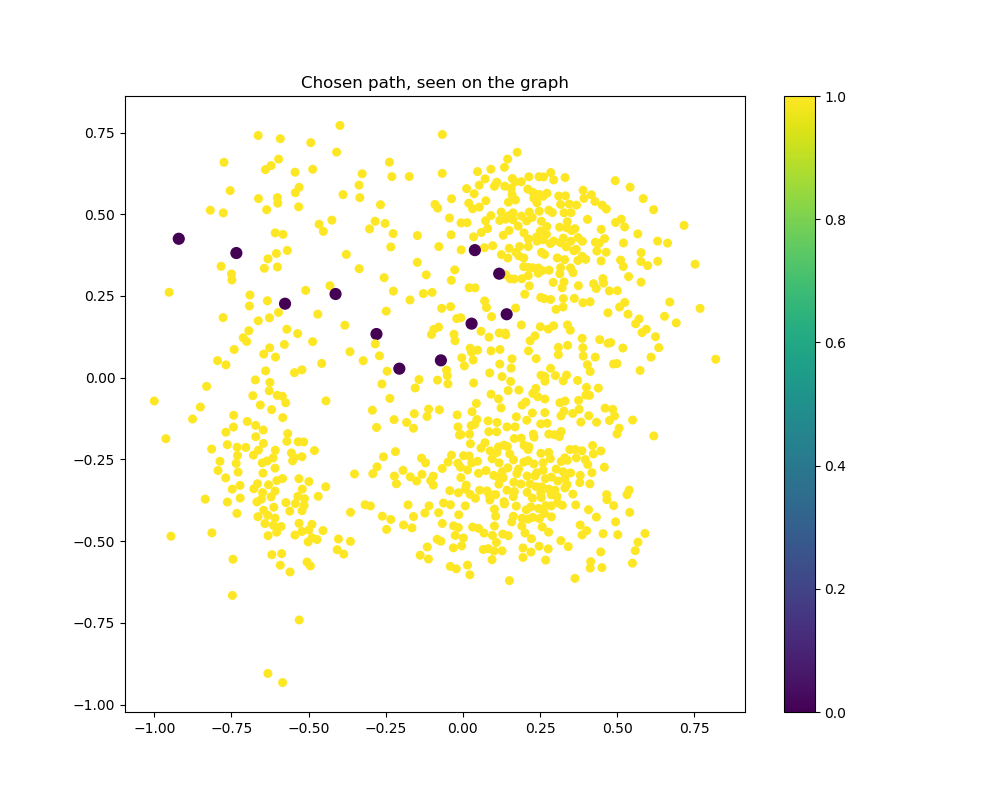

Text(0.5, 1.0, 'Chosen path, seen on the graph')

In [26]:
# node color and node size matrices (for graph visualization)
selected_path_nodes = np.ones([n_nodes])
selected_path_nodes[np.concatenate((s2m_path, m2t_path), axis=None)] = 0
node_size_path = selected_path_nodes*30
node_size_path[node_size_path==0] = 60

# plots the graph and the nodes included in the path with the smallest smoothness
fig = plt.figure(figsize = (10, 8))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size_path, node_color=selected_path_nodes)

plt.colorbar(im)
plt.title('Chosen path, seen on the graph')

## Playlist generation

In [27]:
# converts the path array into a panda object with the informations on the tracks included in the path
def playlist_from_paths(source_to_mid_path, mid_to_target_path):
    
    playlist_track_id = pd.DataFrame(source_to_mid_path + mid_to_target_path[1:len(mid_to_target_path)],\
                                     columns=['node_index'])
    playlist = playlist_track_id.merge(artists_titles, left_on='node_index', right_index=True)
    features = pd.DataFrame(new_out_echonest[['standard_dev', 'average']])
    playlist = playlist.merge(features, left_on='node_index', right_index = True)
    # uncomment next line for the simplified version
    #playlist = playlist[['artist', 'title']] 
    return playlist

In [28]:
playlist = playlist_from_paths(s2m_path, m2t_path)
playlist

,node_index,track_id,artist,title,genre,standard_dev,average
0,214,6716,Tombs,To Cross the Land,Rock,208.852634,44.013989
1,328,37729,Bardo Pond,Absence,Rock,187.787273,36.666708
2,248,14739,Throwing Muses,Say Goodbye,Rock,165.135419,35.728926
3,364,43615,Lorenzo's Music,Indian Summer,Rock,178.305285,39.406680
4,493,110862,Ultimate Painting,Winter In Your Heart,Rock,171.859449,35.945745
5,697,66859,Anitek,Broke Fashion,Electronic,275.776705,55.938209
6,494,110863,Ultimate Painting,Ten Street,Rock,272.117378,53.033893
7,758,27613,El Niño del Parking,Los Dolores de Juana,International,223.700492,52.655255
8,37,21228,Lasswell,Dig Deep Mix,Hip-Hop,203.046682,50.888559
9,676,45507,2NRO8OT,Crash Of The First Interstellar Channel,Electronic,101.837313,32.836562


In [29]:
new_out_echonest.head()

,track_id,standard_dev,average,energy,liveness,tempo,speechiness
0,694,298.207513,69.152355,0.842616,0.066630,98.315,0.563464
1,695,243.527820,57.126724,0.810857,0.362146,166.200,0.106019
2,4682,236.828549,54.039220,0.770144,0.361718,173.992,0.110480
3,4685,145.962993,37.318069,0.605240,0.219908,164.045,0.053686
4,5268,469.231364,98.368473,0.420439,0.074111,150.048,0.415442


In [30]:
pd.DataFrame(signals_array[214][0])

ValueError: DataFrame constructor not properly called!